# GaussPy+ tutorial for a test field of the Galactic Ring Survey

This notebook is intended to guide users through the typical GaussPy+ procedures for the decomposition of a position-position-velocity (PPV) dataset. 

For more information exceeding this tutorial we recommend taking a look at the following papers and documents:

- For a description about the GaussPy+ decomposition package see:
> - [Riener et al. 2019](https://arxiv.org/abs/1906.10506)

- For a description about the GaussPy algorithm see: 
> - [GaussPy documentation](https://gausspy.readthedocs.io/en/latest/)
> - [Lindner et al. 2015](https://arxiv.org/abs/1409.2840)

In [59]:
# import necessary libraries and plotting functions

import os

from astropy.io import fits

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pylab import cm

from astropy.wcs import WCS

from gausspyplus.plotting import get_points_for_colormap, shiftedColorMap


def get_cmap_rchi2(vmin, vmax):
    orig_cmap = matplotlib.cm.RdBu_r
    start, stop = get_points_for_colormap(vmin, vmax, central_val=1.)
    midpoint = (1 - vmin) / (vmax - vmin)
    return shiftedColorMap(orig_cmap, start=0., midpoint=midpoint, stop=stop)


def add_style(ax):
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Latitude')


if not os.path.exists('decomposition_grs'):
    !mkdir decomposition_grs

## Overview

This tutorial consists of the following steps:

- Step 0: Create a configuration file (optional)

- Step 1: Create a training set from the data

- Step 2: Find the optimal values for the smoothing parameters $\alpha_{1}$ and $\alpha_{2}$

- Step 3: Prepare the data for the decomposition

- Step 4: Decomposition of the data

- Step 5: Spatially coherent refitting - phase 1

- Step 6: Spatially coherent refitting - phase 2

- Step 7: Finalize the fitting (optional)


This directory `gausspyplus/data` contains the FITS cube `grs-test_field.fits`, which is a subset of the Galactic Ring Survey (Jackson+ 2006) that we will use for this tutorial. This is the same dataset that was used as a test field in Riener+ 2019.

## Step 0: Create a configuration file (optional)

We start by generating a default configuration file. The next code creates a configuration file called 'gausspy+.ini' in the current working directory.

In [2]:
import gausspyplus.config_file as cf
cf.make()

SAVED FILE: 'gausspy+.ini' in '/Users/riener/iPython_notebooks/gausspyplus_test/example'


This configuration file only contains the most essential parameters, which in many cases should already be sufficient to create first good results. 

To take a look or access the full range of keywords that can be changed by the user change the above command to `cf.make(all_keywords=True)`.

It is not necessary to create a configuration file for running `GaussPy+`. If no configuration file is supplied `GaussPy+` will resort to the default value for the parameters. 

Parameters can also be supplied or changed later on as will be done in the scripts we call further below. 

## Step 1: Create a training set from the data

Now we create a training set from the FITS cube `grs-test_field.fits`. For this we execute the `training_set--grs.py` script contained in the `example` directory. See the `training_set--grs.py` script for more comments.

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

Depending on the number of available CPUs the execution of this script might take a couple of minutes.

In [4]:
#  run the script
!python training_set--grs.py


decompose 100 spectra ...
using 3 out of 4 cpus
100%|█████████████████████████████████████████| 100/100 [12:43<00:00,  7.63s/it]
SUCCESS


SAVED FILE: 'grs-test_field-training_set_100_spectra.pickle' in 'decomposition_grs/gpy_training'

Plotting...






100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]

SAVED FILE: 'grs-test_field-training_set_100_spectra_plots.pdf' in 'decomposition_grs/gpy_training'


### Results
After this script was successfully executed, the `decomposition_grs` directory should contain a folder named `gpy_training` with two files:

- `grs-test_field-training_set_100_spectra.pickle`: a pickled dictionary of the decomposition results of the training set

- `grs-test_field-training_set_100_spectra_plots.pdf`: plots of the decomposition results. We recommend to always plot a subsample of the training set to check whether the fitting of the training set worked out well.

Since this example serves only to illustrate how training sets can be created we kept the number of spectra of the training set deliberately low. We recommend to include at least 200 spectra in the training set to get good results for the smoothing parameters.

## Step 2: Find the optimal values for the smoothing parameters $\alpha_{1}$ and $\alpha_{2}$

After we checked that the decomposition of the training set gave good results, we can supply it to the machine learning procedure that GaussPy employs to find the best smoothing parameters values $\alpha_{1}$ and $\alpha_{2}$. For this we execute the `train--grs.py` script contained in the `example` directory. See the `train--grs.py` script for more comments.

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

Depending on the number of available CPUs the execution of this script might take a couple of minutes.

In [7]:
#  run the script
!python train--grs.py


GaussPy training
Using training set: decomposition_grs/gpy_training/grs-test_field-training_set_100_spectra.pickle
Training...

2.0, 0.9, 0.0, 0.0
iter 0: F1=67.7%, alpha=[2.0, 6.0], p=[0.00, 0.00]  (Convergence testing begins in 20 iterations)

2.0, 0.9, 0.016194420465238557, 0.0
iter 1: F1=67.6%, alpha=[2.0, 5.93], p=[0.00, -0.06]  (Convergence testing begins in 19 iterations)

1.9854250215812852, 0.9, -0.03200068269288214, -0.011659982734971841
iter 2: F1=67.9%, alpha=[1.99, 5.85], p=[-0.01, -0.07]  (Convergence testing begins in 18 iterations)

2.002565653269907, 0.9, -0.010403832312573247, 0.01371250535089761
iter 3: F1=69.0%, alpha=[2.0, 5.74], p=[0.01, -0.09]  (Convergence testing begins in 17 iterations)

2.0256416077021204, 0.9, 0.004886587434413947, 0.018460763545770576
iter 4: F1=69.1%, alpha=[2.03, 5.61], p=[0.02, -0.10]  (Convergence testing begins in 16 iterations)

2.0397044425569186, 0.9, 0.004424780565881581, 0.011250267883838561
iter 5: F1=70.6%, alpha=[2.04, 5.49], 

### Results

In our case, we needed 47 iterations until a stable convergence was achieved. This yielded values for the smoothing parameters of $\alpha_{1} = 2.58$ and $\alpha_{2} = 5.14$.

Note that the `decomposition_grs` directory now contains a new folder named `gpy_log`, which contains a log of the training results. 

## Step 3: Prepare the data for the decomposition

Next, we have to prepare our data cube for the decomposition. Executing the script `prepare--grs.py` will automatically:

- estimate the root-mean-square noise $\sigma_{\mathrm{rms}}$ of the spectra

- determine regions in the spectra that are likely to contain signal peaks

- mask out negative noise spikes (by default all data peaks with a minimum $< -5 \times \sigma_{\mathrm{rms}}$)

- produce a pickled dictionary containing all necessary information for the decomposition

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

In [13]:
#  run the script
!python prepare--grs.py



calculating average rms from data...
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1607.55it/s]
>> calculated rms value of 0.134 from data

GaussPy preparation

preparing GaussPy cube...
Using 3 of 4 cpus
100%|███████████████████████████████████████| 4.20k/4.20k [00:04<00:00, 864it/s]
4197it [00:00, 456049.06it/s]
SUCCESS

4200it [00:00, 116449.14it/s]

pickle dump dictionary...
For GaussPyDecompose: 'path_to_pickle_file' = 'decomposition_grs/gpy_prepared/grs-test_field.pickle'

SAVED FILE: 'grs-test_field_noise_map.fits' in 'decomposition_grs/gpy_maps'

Plotting...






100%|███████████████████████████████████████████| 25/25 [00:03<00:00,  7.89it/s]

SAVED FILE: 'grs-test_field_plots.pdf' in 'decomposition_grs/gpy_plots'


### Results
After this script was successfully executed, the `decomposition_grs` directory should contain a folder named `gpy_prepared` that contains `grs-test_field.pickle`, which is a pickled dictionary of the prepared data cube.

The `decomposition_grs` directory should also contain a new folder named `gpy_maps` that contains the file `grs-test_field_noise_map.fits`, which is a map of the estimated rms noise values of our GRS test field.

Lets take a look at the noise map:

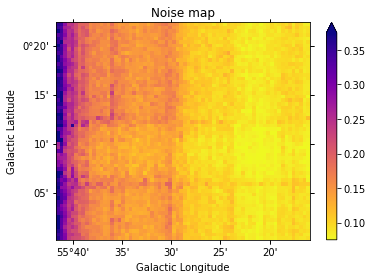

In [55]:
filepath = os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_noise_map.fits')
noise = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(projection=wcs))

img_noise = ax.imshow(noise, cmap='plasma_r', vmin=0.075, vmax=0.375)
fig.colorbar(img_noise, ax=ax, extend='max')
ax.set_title('Noise map')
add_style(ax)

plt.show()

The `prepare--grs.py` script also plotted all spectra within pixel ranges $30 \leq \text{X} \leq 34$ and $25 \leq \text{Y} \leq 29$ and saved it as `grs-test_field_plots.pdf` in the `gpy_plots` directory.

The spectra are plotted in the correct spatial order to aid in comparing differences between neighboring spectra. The shaded red areas indicate the regions of the spectrum that were identified to contain signal (goodness of fit calculations are restricted to these areas). The dotted horizontal red lines indicate the estimated noise values of $\pm \sigma_{\mathrm{rms}}$ and the horizontal dashed line marks a S/N ratio of 3. The title of each subplot contains information about the location in terms of pixels and the index of the spectrum in the `grs-test_field.pickle` dictionary.

## Step 4: Decomposition of the data

After the successful preparation of the data, we can proceed to the decomposition of the data. 

The following script will run an improved fitting routine on top of the original GaussPy decomposition routine; for more details see Sect. 3.2. in Riener+ 2019.

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

Depending on the number of available CPUs the execution of this script might take a couple of minutes.

In [43]:
#  run the script
!python decompose--grs.py




pickle load 'grs-test_field.pickle'...







GaussPy decomposition

decomposition settings:
GaussPy:
Two phase decomposition: True
alpha1: 2.58
alpha2: 5.14
SNR1: 3.0
SNR2: 3.0

improve_fitting: True
min_fwhm: 1.0
max_fwhm: None
snr: 3.0
snr_fit: 1.5
significance: 5.0
snr_negative: 3.0
rchi2_limit: None
max_amp_factor: 1.1
neg_res_peak: True
broad: True
blended: True
fwhm_factor: 2.0
separation_factor: 0.8493218
exclude_means_outside_channel_range: True
min_pvalue: 0.01
max_ncomps: None

decomposing data...
using 3 out of 4 cpus
100%|██████████████████████████████████████| 4.20k/4.20k [03:32<00:00, 19.8it/s]
4199it [00:00, 298754.60it/s]

pickle dump GaussPy final results...
SAVED FILE: 'grs-test_field_g+_fit_fin.pickle' in 'decomposition_grs/gpy_decomposed'

making component map...
SAVED FILE: 'grs-test_field_g+_component_map.fits' in 'decomposition_grs/gpy_maps'

making reduced chi2 map...
SAVED FILE: 'grs-test_field_g+_rchi2_map.fits' in 'decomposition_grs/gpy_maps'

Plotting...

### Results
After this script was successfully executed, the `decomposition_grs` directory should contain a folder named `gpy_decomposed` that contains `grs-test_field_g+_fit_fin.pickle`, which is a pickled dictionary of the decomposition results.

In addition, we also produced a map showing the number of fitted components and a map showing the $\chi_{\mathrm{red}}^{2}$ values of the fit. 

Lets take a look at both of these maps:

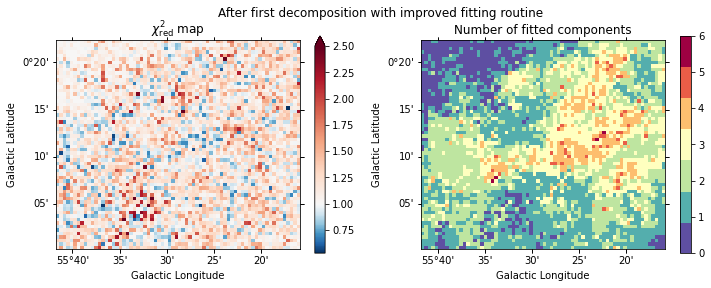

In [56]:
filepath = os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_g+_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_g+_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After first decomposition with improved fitting routine')

plt.show()

## Step 5: Spatially coherent refitting - phase 1

Next we will try to improve upon the decomposition results obtained in the last step. For this, we try to refit spectra that were flagged as not satisfying our chosen quality criteria. For more details see Sect.$\,$3.3.1. in Riener+ 2019 for more details.

For this we execute the `spatial_refitting-p1--grs.py` script contained in the `example` directory. See the `spatial_refitting-p1--grs.py` script for more comments.

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

Depending on the number of available CPUs the execution of this script might take a couple of minutes.

In [49]:
#  run the script
!python spatial_refitting-p1--grs.py


Spatial refitting - Phase 1

Flagging:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   flagged if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: True
 - Differing number of components: True

For phase 1:
Exclude flagged spectra as possible refit solutions in first refit attempts: False
Use also flagged spectra as refit solutions in case no new best fit could be obtained from unflagged spectra: False

Refitting:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   try to refit if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: Fal

100%|███████████████████████████████████████████| 25/25 [00:07<00:00,  3.19it/s]

SAVED FILE: 'grs-test_field_g+_fit_fin_sf-p1_plots.pdf' in 'decomposition_grs/gpy_plots'


### Results
After this script was successfully executed, the `gpy_decomposed` folder contains the new file `grs-test_field_g+_fit_fin_sf-p1.pickle`, which is a pickled dictionary of the new decomposition results.

In addition, we also produced new corresponding mapa of the number of fitted components and $\chi_{\mathrm{red}}^{2}$ values of the fit. 

Lets take a look again at both of these maps:

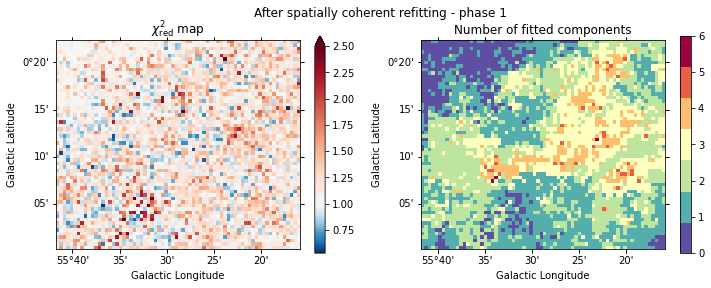

In [57]:
filepath = os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_g+_fit_fin_sf-p1_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
header = fits.getheader(filepath)
wcs = WCS(header)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(
    os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_g+_fit_fin_sf-p1_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After spatially coherent refitting - phase 1')

plt.show()

We can see that the $\chi_{\mathrm{red}}^{2}$ values of the fit did not change significantly; however the map of the number of fitted components shows already more spatial coherence. We can also check the new fit results for our 25 neighboring spectra that are plotted in `grs-test_field_g+_fit_fin_sf-p1_plots.pdf`. These plots also confirm that we gained a significant improvement in terms of spatial coherence of the fit results.

## Step 6: Spatially coherent refitting - phase 2

In the last step, we try to further improve upon the decomposition results obtained in the last step by checking the coherence of the centroid positions of the fitted Gaussian components. See Sect.$\,$3.3.2. in Riener+ 2019 for more details.

For this we execute the `spatial_refitting-p2--grs.py` script contained in the `example` directory. See the `spatial_refitting-p2--grs.py` script for more comments.

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

Depending on the number of available CPUs the execution of this script might take a couple of minutes.

In [51]:
#  run the script
!python spatial_refitting-p2--grs.py


Spatial refitting - Phase 2

Flagging:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   flagged if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: True
 - Differing number of components: True

threshold for required components: 0.833

 Flags:
 - 79 spectra w/ blended components
 - 3 spectra w/ negative residual feature
 - 709 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 141 channels)
 - 0 spectra w/ high rchi2 value
 - 817 spectra w/ residual not passing normality test
 - 36 spectra w/ differing number of components

check which spectra require refitting...

determine neighbors for all spectra...
4200it [00:03, 1150.07it/s]

start refit iteration #1...
Using 3 of 4 cpus
100%|██████████████████████████████████████| 4.20k/4.20k [01:49<00:00, 38.4


making component map...
SAVED FILE: 'grs-test_field_g+_fit_fin_sf-p2_component_map.fits' in 'decomposition_grs/gpy_maps'

making reduced chi2 map...
SAVED FILE: 'grs-test_field_g+_fit_fin_sf-p2_rchi2_map.fits' in 'decomposition_grs/gpy_maps'

Plotting...




100%|███████████████████████████████████████████| 25/25 [00:07<00:00,  3.36it/s]

SAVED FILE: 'grs-test_field_g+_fit_fin_sf-p2_plots.pdf' in 'decomposition_grs/gpy_plots'


### Results
After this script was successfully executed, the `gpy_decomposed` folder contains the new file `grs-test_field_g+_fit_fin_sf-p2.pickle`, which is a pickled dictionary of the new decomposition results.

In addition, we also produced new corresponding maps of the number of fitted components and $\chi_{\mathrm{red}}^{2}$ values of the fit. 

Lets take a look again at both of these maps:

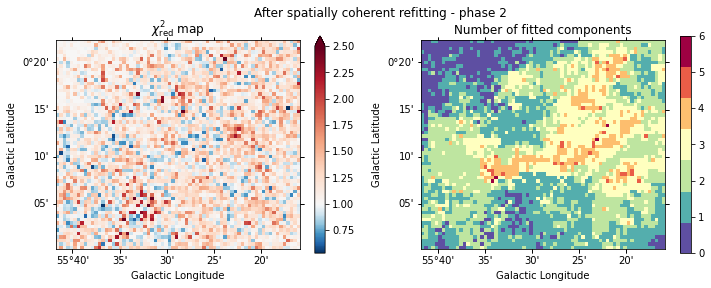

In [58]:
filepath = os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_g+_fit_fin_sf-p2_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(
    os.path.join('decomposition_grs', 'gpy_maps', 'grs-test_field_g+_fit_fin_sf-p2_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After spatially coherent refitting - phase 2')

plt.show()

Judging by the map showing the number of fitted components we seem to have gained more spatial coherence. The new and final fit results for our 25 neighboring spectra are plotted in `grs-test_field_g+_fit_fin_sf-p2_plots.pdf`.

## Step 7: Finalize the fitting (optional)

Finally, we can produce a table containing the final fit results from the second phase of the spatially coherent refitting stage.

**NOTE: Running this script will use 75% of all CPUs on the machine you are running it unless the** `use_ncpus` **parameter is specified.**

In [53]:
#  run the script
!python finalize--grs.py








check which spectra require refitting...

determine neighbors for all spectra...
4200it [00:04, 864.93it/s]

start refit iteration #1...
Using 3 of 4 cpus
100%|███████████████████████████████████████| 4.20k/4.20k [00:11<00:00, 372it/s]
4197it [00:00, 407045.43it/s]
SUCCESS
Using 3 of 4 cpus
100%|█████████████████████████████████████| 4.20k/4.20k [00:03<00:00, 1.37kit/s]
4197it [00:00, 336053.56it/s]
SAVED FILE: 'grs-test_field_g+_fit_fin_sf-p2_finalized.dat' in 'decomposition_grs/gpy_decomposed'


### Results
After this script was successfully executed, the `gpy_decomposed` folder contains the new file `grs-test_field_g+_fit_fin_sf-p2_finalized.dat`, which is a table containing the entire decomposition results.

By default the table is similar to Table presented in [Riener et al. 2020](https://arxiv.org/abs/1911.06860) (see Sect. 3.1 in [Riener et al. 2020](https://arxiv.org/abs/1911.06860) for a description of the table columns).

### Note
We could have combined the preparation and decomposition steps in a single script, but for illustrative purposes we have executed them seperately in this tutorial.